<H1> Supervised Learning Continued - What Could Go Wrong?

In this lab, we will demonstrate some common pitfalls that may be encountered in performing a supervised learning analysis. To this end, we will simulate data under the null (meaning, we will simulate no relationship between outcome and independent variables) to observe situations where we may commit type I error.

In [23]:
## Supervised

# Simulate noisy data matrix (EXPRS)
set.seed(123)
# We'll use 2 groups of 20 subjects - think 20 cases and 20 controls
n=20
# Simulate 1000 genes
m=1000

# randomly generate a matrix of 'expression levels' -- any continuous variable we may be interested in
EXPRS=matrix(rnorm(2*n*m),2*n,m)

# Just naming rows and columns
rownames(EXPRS)=paste("patient",1:(2*n),sep="")
colnames(EXPRS)=paste("gene exp",1:m,sep="")

# The group labels are assigned arbitrarily - i.e. we are just randomly assigning 
#                case/control status with no reference to gene expression
grp=rep(0:1,c(n,n))


In [24]:
#Pick the top 10 features based on the 
#two-sample $t$-test

# load the library 'genefilter' - part of the Bioconductor suite
library(genefilter)

# rowttests is a genefilter function that performs a student t test on rows.

ttest.data=rowttests(t(EXPRS), factor(grp))
head(ttest.data)

,statistic,dm,p.value
gene exp1,0.6746243,0.192881,0.5039985
gene exp2,0.7417175,0.2264023,0.4628184
gene exp3,3.025423,0.7344752,0.004436959
gene exp4,0.4030939,0.1349871,0.6891382
gene exp5,0.9545301,0.3004477,0.3458485
gene exp6,0.3305064,0.09782354,0.7428327


In [25]:
# Extract the absolute value of the statistic
stats=abs(ttest.data$statistic)

# 'order' will return the indices of ascending values of it's argument
ii=order(-stats)

#Filter out all genes (i.e. columns of the matrix) except the top 10 rated by stats

TOPEXPRS=EXPRS[, ii[1:10]]
dim(TOPEXPRS)

[1] 40 10

Now we will perform a 3-nearest-neighbor clustering, just like we did with the health dynamics class data.

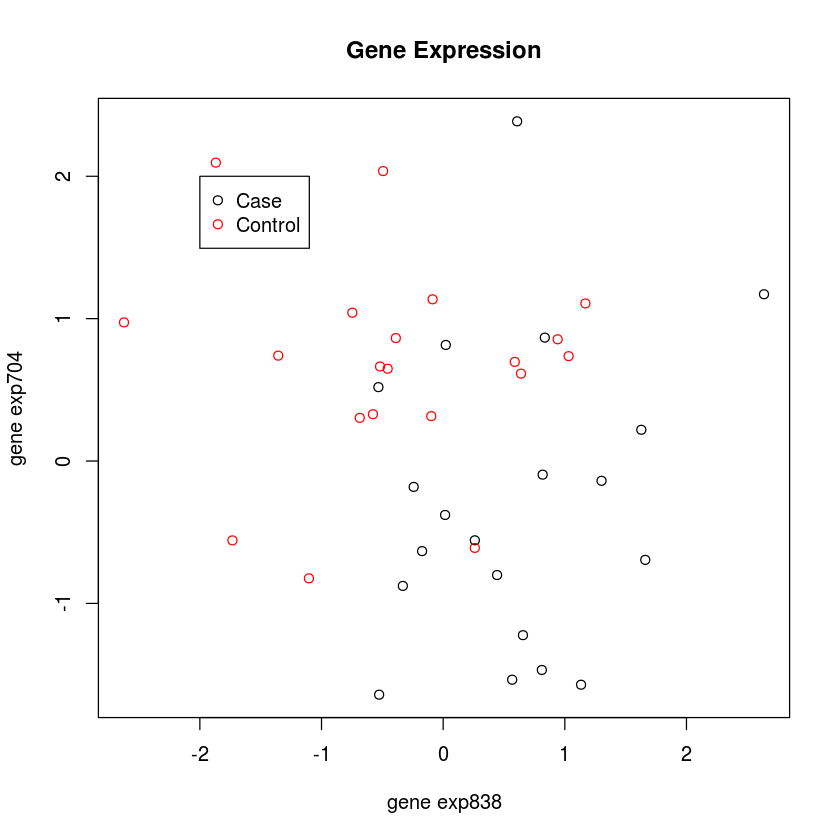

In [26]:
plot(TOPEXPRS, col=grp+1,
      main="Gene Expression")
legend(-2, 2, c("Case", "Control"), pch=1, col=1:2)

In [27]:
# Fit 3-NN
library(class)
mod0=knn(train=TOPEXPRS,test=TOPEXPRS,cl=grp,k=3)
print(mod0)

# Error Resubstituion
table(mod0,grp)


 [1] 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1
Levels: 0 1


    grp
mod0  0  1
   0 17  0
   1  3 20

In [28]:
# Naive CV
mod1=knn.cv(TOPEXPRS,grp,k=3)
table(mod1,grp)


    grp
mod1  0  1
   0 16  0
   1  4 20

This looks like differential gene expression. We can accurately predict case-control status, based on gene expression. But, we haven't cross-validated. And we have only 40 subjects and have looked at 1000 genes! Let's do it the right way now. This is like tossing a coin 40 times, and repeating that 1000 times. We *will* see some very long strings of heads and tails in some replicates - just by chance!

In [29]:
# Oh! Super fancy code! I'll rewrite if there is time. Otherwise, we need to skip through.

# Proper CV
top.features=function(EXP,resp,test,fsnum)
  {
    top.features.i=function(i,EXP,resp,test,fsnum)
      {
        stats=abs(mt.teststat(EXP[,-i],resp[-i],test=test))
        ii=order(-stats)[1:fsnum]
        rownames(EXP)[ii]
      }
    sapply(1:ncol(EXP),top.features.i,EXP=EXP,resp=resp,test=test,fsnum=fsnum)
  }




In [30]:
# This function evaluates the knn

knn.loocv=function(EXP,resp,test,k,fsnum,tabulate=FALSE,permute=FALSE)
  {
    if(permute)
      resp=sample(resp)
    topfeat=top.features(EXP,resp,test,fsnum)
    pids=rownames(EXP)
    EXP=t(EXP)
    colnames(EXP)=as.character(pids)
    knn.loocv.i=function(i,EXP,resp,k,topfeat)
      {
        ii=topfeat[,i]
        mod=knn(train=EXP[-i,ii],test=EXP[i,ii],cl=resp[-i],k=k)[1]
      }
    out=sapply(1:nrow(EXP),knn.loocv.i,EXP=EXP,resp=resp,k=k,topfeat=topfeat)
    if(tabulate)
      out=ftable(pred=out,obs=resp)
    return(out)
}



In [31]:
library(multtest)
knn.loocv(t(EXPRS),as.integer(grp),"t.equalvar",3,10,TRUE)


Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citatio

     obs  0  1
pred          
0         7  7
1        13 13

Well, now that looks right! We are no longer fitting noise. What's the difference? Everytime we perform a validation step, we need to re-evaluate the top ten picks! 